In [1]:
import sqlite3 as sql
import regex as re
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
conn = sql.connect(r'C:\Users\ajk51\Desktop\Lichess Analysis\lichess game data.db')
cur = conn.cursor()

In [6]:
match_types = dict(cur.execute('''SELECT COUNT (game_id), game_type 
                    FROM games_metadata
                    GROUP BY game_type''').fetchall())


Text(0.5, 1.0, 'Distribution of Game Types')

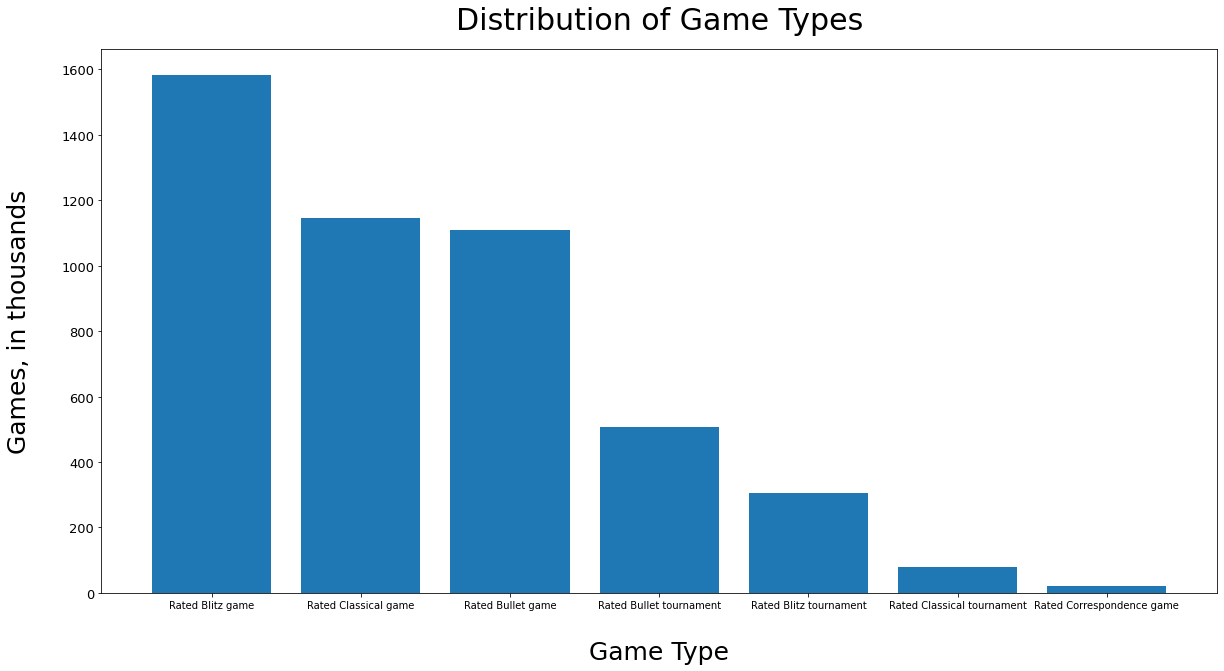

In [115]:
labels = []
for num in sorted(match_types.keys(), reverse=True):
    labels.append(match_types[num])

values = list(map(lambda x : x/1000, sorted(match_types.keys(), reverse=True)))

plt.figure(figsize=(20,10))
plt.bar(x=labels, height= values)

plt.xlabel('Game Type', fontsize=25, labelpad=30)
plt.xticks(fontsize=10)

plt.ylabel('Games, in thousands', fontsize=25, labelpad=30)
plt.yticks(fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Distribution of Game Types', fontsize=30, pad=20)



In [89]:
win_breakdown = dict(cur.execute('''SELECT COUNT (game_id), winner 
                    FROM games_metadata
                    GROUP BY winner''').fetchall())


Text(0.5, 1.0, 'Who Wins')

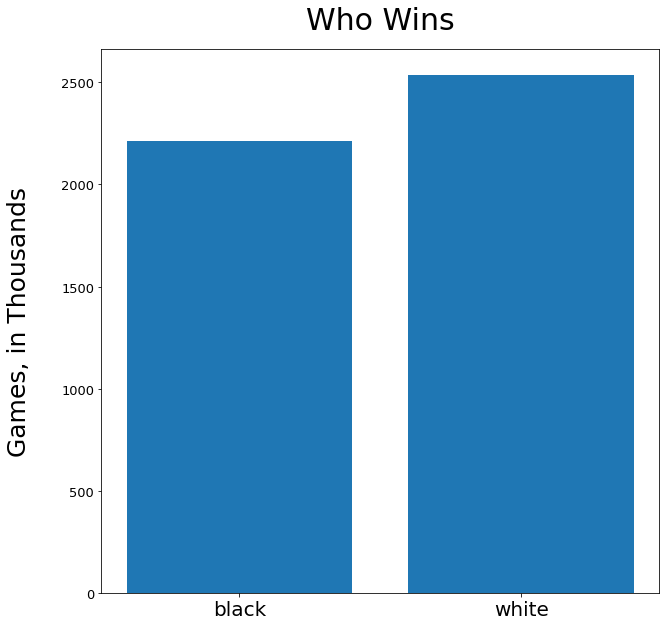

In [134]:
win_values = list(map(lambda x: x/1000, win_breakdown.keys()))

win_labels = win_breakdown.values()

plt.figure(figsize=(10,10))
plt.bar(x=win_labels, height= win_values)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Games, in Thousands', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Who Wins', fontsize=30, pad=20)


In [117]:
win_type = dict(cur.execute('''SELECT COUNT (game_id), game_end 
                    FROM games_metadata
                    GROUP BY game_end''').fetchall())

Text(0.5, 1.0, 'How Games End')

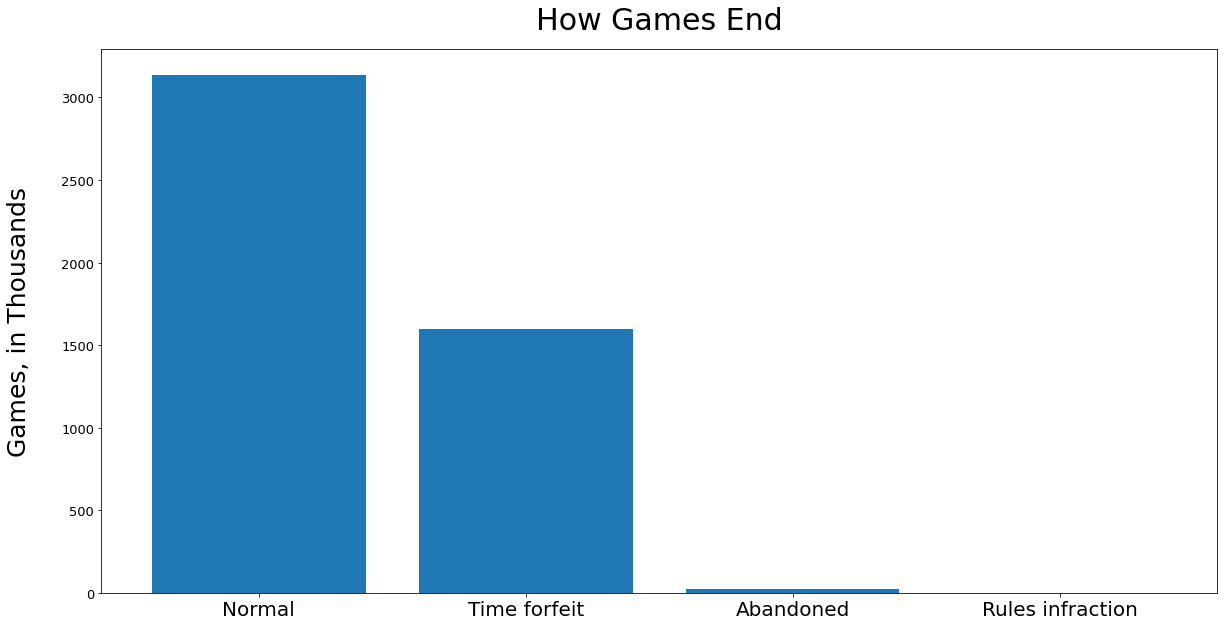

In [133]:
win_types_values = list(map(lambda x: x/1000, sorted(win_type.keys(), reverse=True)))

win_types_labels = []
for num in sorted(win_type.keys(), reverse=True):
    win_types_labels.append(win_type[num])

plt.figure(figsize=(20,10))
plt.bar(x=win_types_labels, height= win_types_values)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Games, in Thousands', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('How Games End', fontsize=30, pad=20)



In [36]:
black_elos = dict((cur.execute('''SELECT ROUND(black_elo/10, 1)*10    AS bucket,
       COUNT(game_id)                    AS COUNT
FROM   games_metadata
GROUP  BY bucket''')).fetchall())

Text(0.5, 1.0, 'Black Player Ratings')

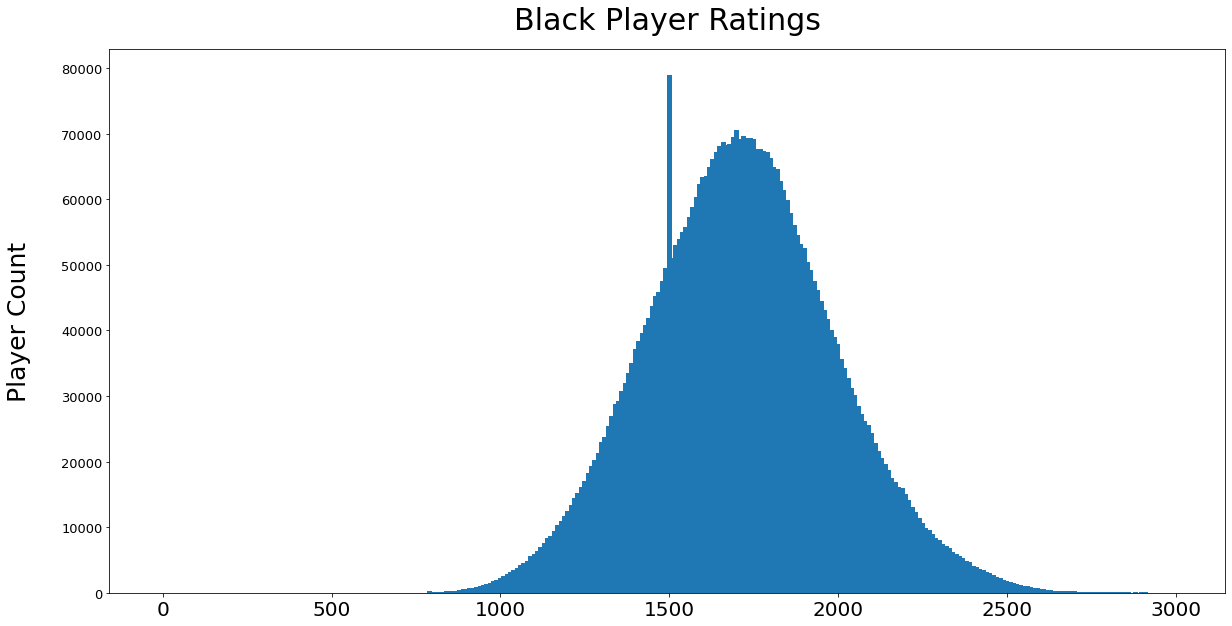

In [37]:
black_elos_values = list(black_elos.values())

black_elos_labels = list(black_elos.keys())

plt.figure(figsize=(20,10))
plt.bar(x=black_elos_labels, height= black_elos_values, width=15)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Player Count', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Black Player Ratings', fontsize=30, pad=20)


In [39]:
white_elos = dict((cur.execute('''SELECT ROUND(white_elo/10, 1)*10    AS bucket,
       COUNT(game_id)                    AS COUNT
FROM   games_metadata
GROUP  BY bucket''')).fetchall())

Text(0.5, 1.0, 'White Player Ratings')

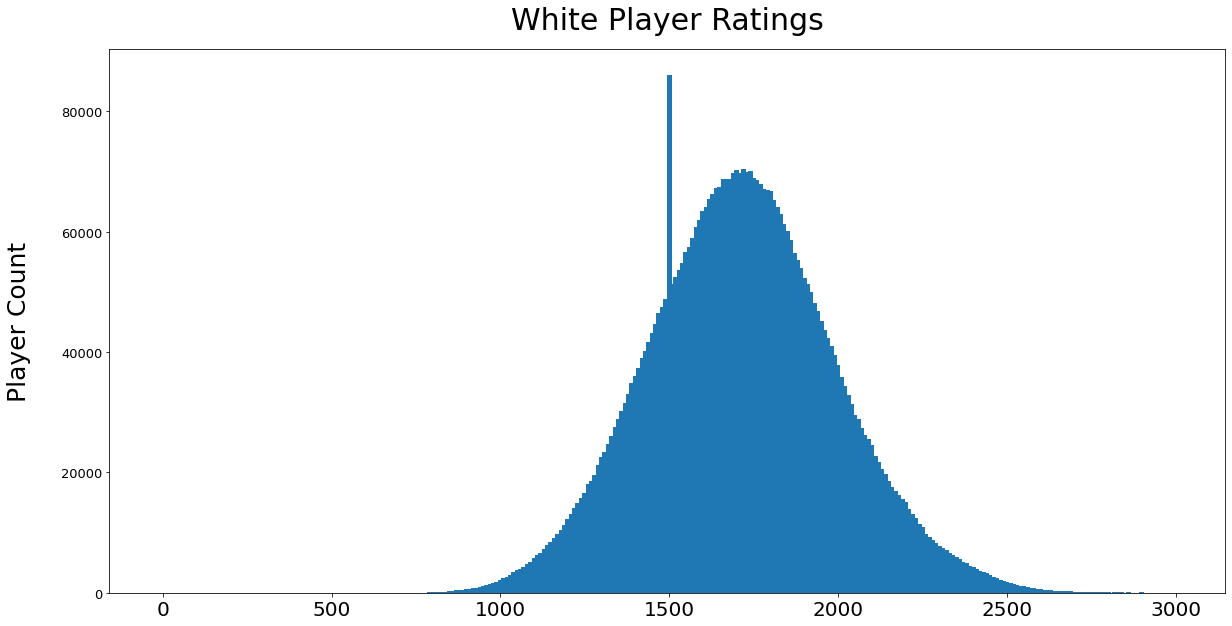

In [40]:
white_elos_values = list(white_elos.values())

white_elos_labels = list(white_elos.keys())

plt.figure(figsize=(20,10))
plt.bar(x=white_elos_labels, height= white_elos_values, width=15)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Player Count', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('White Player Ratings', fontsize=30, pad=20)


In [41]:
moves = dict((cur.execute('''SELECT number_of_moves, count(game_id)
FROM games_metadata
GROUP BY number_of_moves''')).fetchall())

Text(0.5, 1.0, 'Move Count')

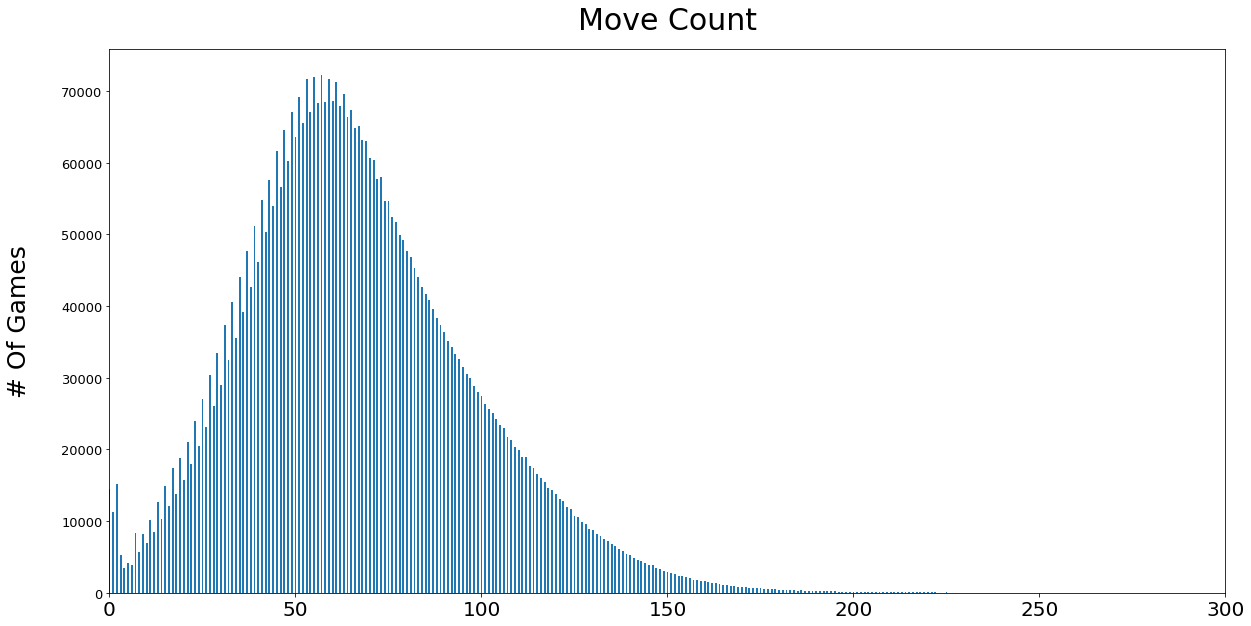

In [60]:
moves_values = list(moves.values())

moves_labels = list(moves.keys())

plt.figure(figsize=(20,10))
plt.bar(x=moves_labels, height= moves_values, width=.5)

plt.xticks(fontsize=20)
plt.xlim(left=0, right=300)

plt.yticks(fontsize=13)
plt.ylabel('# Of Games', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Move Count', fontsize=30, pad=20)


In [19]:
rating_diff = dict(cur.execute('''SELECT ROUND((white_elo - black_elo)/2)*2    AS bucket,
       COUNT(game_id)                    AS COUNT
FROM   games_metadata
GROUP  BY bucket;''').fetchall())

Text(0.5, 1.0, 'ELO Difference')

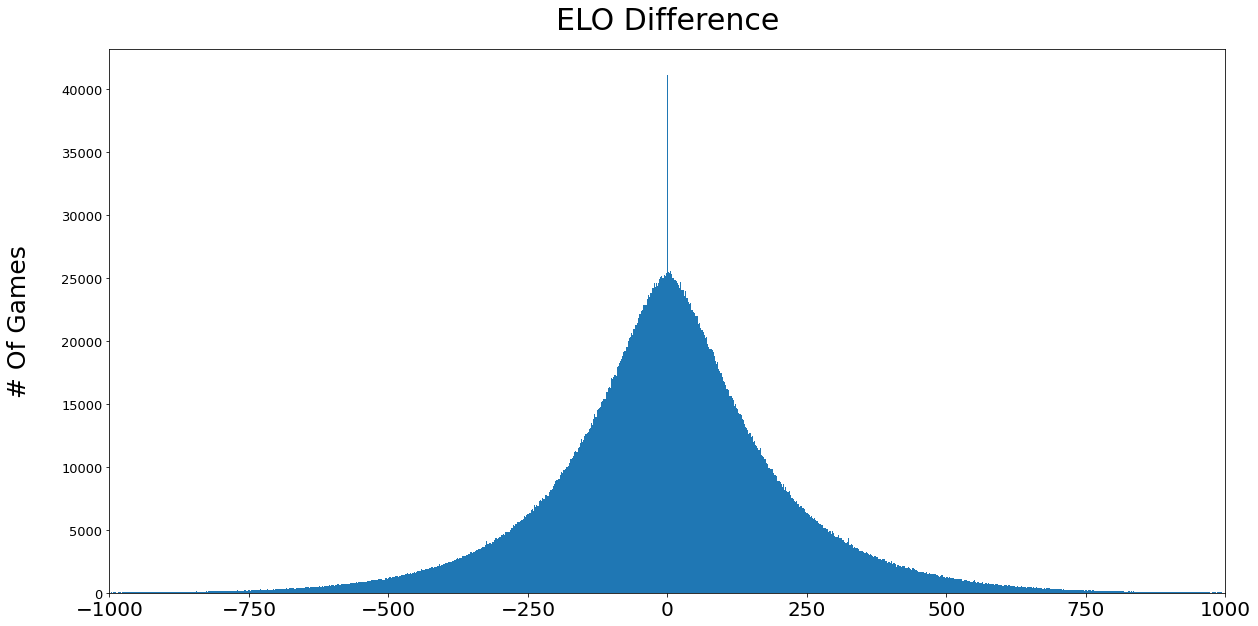

In [22]:
diff_values = list(rating_diff.values())

diff_labels = list(rating_diff.keys())

plt.figure(figsize=(20,10))
plt.bar(x=diff_labels, height= diff_values, width=2)

plt.xticks(fontsize=20)
plt.xlim(left=-1000, right=1000)

plt.yticks(fontsize=13)
plt.ylabel('# Of Games', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('ELO Difference', fontsize=30, pad=20)

In [25]:
diff_dive = dict(cur.execute('''SELECT ROUND((white_elo/10)*10) AS bucket,
       COUNT(game_id)                    AS COUNT
FROM   games_metadata
WHERE white_elo = black_elo
GROUP  BY bucket;''').fetchall())

Text(0.5, 1.0, 'Same ELO Matches')

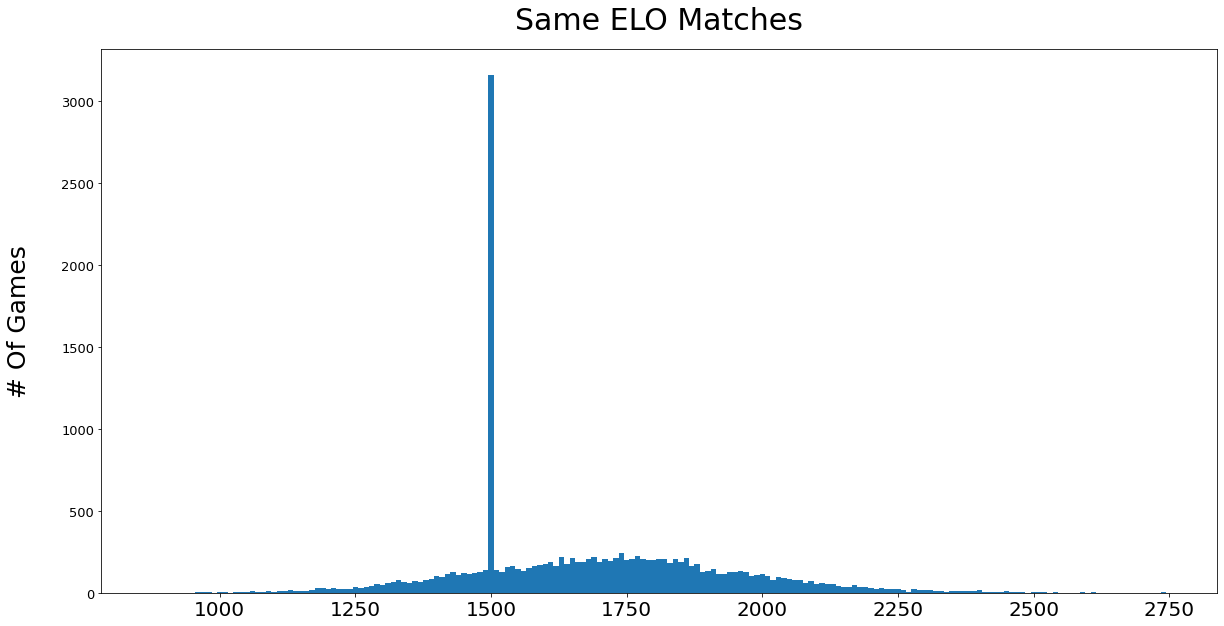

In [27]:
dd_values = list(diff_dive.values())

dd_labels = list(diff_dive.keys())

plt.figure(figsize=(20,10))
plt.bar(x=dd_labels, height= dd_values, width=10)

plt.xticks(fontsize=20)
#plt.xlim(left=0, right=300)

plt.yticks(fontsize=13)
plt.ylabel('# Of Games', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Same ELO Matches', fontsize=30, pad=20)

In [28]:
moves_vs_end = cur.execute('''SELECT 
        number_of_moves, 
        count(CASE WHEN game_end='Normal' THEN 1 END) as Normal_end,
        count(CASE WHEN game_end='Time forfeit' THEN 1 END) as Time_end
    FROM games_metadata
    GROUP BY number_of_moves
    ;''').fetchall()

<AxesSubplot:title={'center':'Length of Game, by End Type'}, xlabel='Moves'>

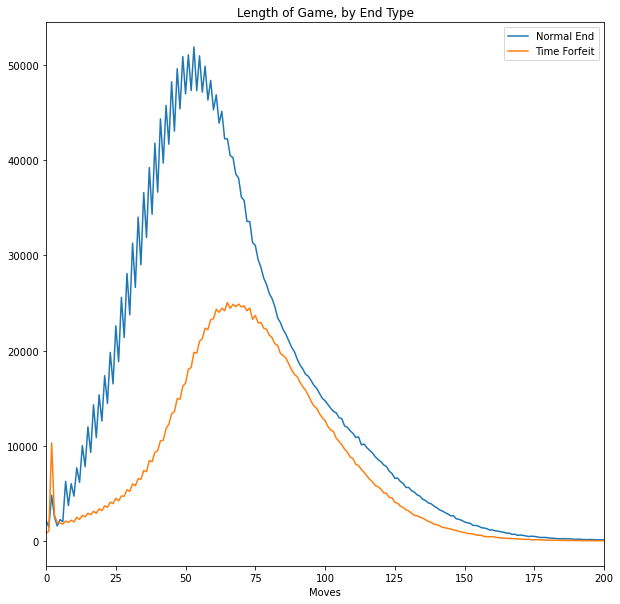

In [49]:
mve_df = pd.DataFrame(moves_vs_end, columns=['Moves', 'Normal End', 'Time Forfeit'])

mve_df.plot(x='Moves', figsize=(10,10), title='Length of Game, by End Type', xlim=(0,200))

In [7]:
def generate_pieces():
    '''Defines pieces with unique letter/number ID. To be chained with populate_board and make_move_dict'''
    
    nums = []
    for x in range(1,17):
        nums.append(str(x))

    pawns = []
    rooks  = []
    knights = []
    bishops = []
    kings = []
    queens = []

    for x in range(16):
        pawns.append('p'+nums[x])

    for x in range(4):
        rooks.append('r'+nums[x])
        knights.append('n'+nums[x])
        bishops.append('s'+nums[x])

    for x in range(2):
        kings.append('k'+nums[x])
        queens.append('q'+nums[x])
    
    return pawns, rooks, knights, bishops, kings, queens

In [8]:
pawns, rooks, knights, bishops, kings, queens = generate_pieces()

In [45]:
query_list = pawns + rooks + knights + bishops + kings + queens
backrow_query = rooks + knights + bishops + kings + queens

w_backrow = rooks[0:2] + knights[0:2] + bishops[0:2] + [queens[0]] + [kings[0]]
b_backrow = rooks[2:] + knights[2:] + bishops[2:] + [kings[1]] + [queens[1]]

In [62]:
x = cur.execute('''SELECT count(p1)
FROM(	
	SELECT moves_by_piece.p1
	FROM moves_by_piece
	JOIN games_metadata
	ON moves_by_piece.game_id = games_metadata.game_id
	WHERE games_metadata.number_of_moves >2
	)
WHERE p1 LIKE '%q_';''').fetchone()[0]

In [49]:
#query results dict setup

test = dict.fromkeys(query_list)
for x in pawns[:8] + w_backrow:
    test[x] = dict.fromkeys(pawns[8:] + b_backrow)
for x in (pawns[8:] + b_backrow):
    test[x] = dict.fromkeys(pawns[:8] + w_backrow)

In [66]:
#Query template

x = cur.execute(F'''SELECT count({q})
FROM(	
	SELECT moves_by_piece.{q}
	FROM moves_by_piece
	JOIN games_metadata
	ON moves_by_piece.game_id = games_metadata.game_id
	WHERE games_metadata.number_of_moves >2
	)
WHERE {q} LIKE '%{u[0]}_';''').fetchone()[0]